# Loading embeddings from a pretrained model

Last updated on Mar 21 2022 by Cristobal D.

In [1]:
cd ../..

/home/cridonoso/Documents/astromer


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf 
import pandas as pd
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"]="-1"

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

%load_ext autoreload
%autoreload 2

2022-03-21 11:47:16.503055: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-21 11:47:16.503072: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Loading pre-trained weights

We need to import the `ASTROMER` class to instanciate the model 

In [344]:
from core.astromer import ASTROMER

Use the project directory (`experiment_path`) where weights, config and logs are stored.

In [345]:
experiment_path = './runs/debug/'

Let's instanciate a clean `ASTROMER` class and then load the weigths

In [346]:
model = ASTROMER()
model.load_weights(experiment_path)

our model is ready to be used. We can explore the number of parameters by using, 

In [347]:
model.summary()

Model: "astromer_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  660736    
                                                                 
 regression (RegLayer)       multiple                  769       
                                                                 
Total params: 661,505
Trainable params: 661,505
Non-trainable params: 0
_________________________________________________________________


By default the model loads the `RegLayer` regression layer in charge of reconstructing light curves magnitudes during pre-training and finetuning. 

However if we only need to import the `encoder` layer, we can get it from the `ASTROMER` class as following:

In [348]:
encoder = model.get_layer('encoder')

### Load data 

At this version, `ASTROMER` is able to work with single-band light curves. It should be composed by observational times (`mjd`), mean brightness (`magnitude`), and observational error (`std`).

In this tutorial we use the [ALeRCE ztf python client](https://alerce.readthedocs.io/en/latest/index.html) 

In [3]:
from alerce.core import Alerce
alerce = Alerce()

In [208]:
%%time
samples_collection = []
oids_list = ['ZTF18aabkmmz', 'ZTF18abbuksn', 'ZTF17aaaecwh']
for oid in oids_list:
    sample = alerce.query_detections(oid, format="pandas")
    sample = sample[sample['fid']==1] # getting single band light curve
    sample = sample[['mjd', 'magpsf', 'sigmapsf']] # use only necessary columns
    samples_collection.append(sample.values)

CPU times: user 96.6 ms, sys: 0 ns, total: 96.6 ms
Wall time: 2.79 s


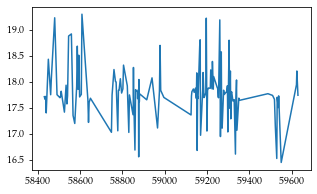

In [209]:
plt.figure(figsize=(5,3))
plt.plot(samples_collection[0][:, 0], samples_collection[0][:, 1])
plt.show()

### Getting embedding 

In [389]:
%%time
embeddings = model.encode(samples_collection, 
                          oids_list=oids_list,
                          batch_size=3, 
                          concatenate=False)

[INFO] Inference mode. Cutting 200-len windows
CPU times: user 585 ms, sys: 0 ns, total: 585 ms
Wall time: 444 ms


`ASTROMER` can only recieve 200-len series. Since light curves have vary-lenght, the `encode()` method will divide the samples in order to capture 200-len windows.

If any window does not have enough observations, we shift the window to start from the last observation, so zero-padding is not used.

In [392]:
embeddings.shape

(9, 200, 256)

by setting `concatenate=True` you can get the concatenation of all id-related windows

In [398]:
%%time
att = model.encode(samples_collection, 
                   oids_list=oids_list, 
                   batch_size=3, 
                   concatenate=True)

[INFO] Inference mode. Cutting 200-len windows
CPU times: user 741 ms, sys: 17.7 ms, total: 759 ms
Wall time: 599 ms


In [399]:
att[0].shape

(1200, 256)

Notice the `att` is a list of variable length **concatenated** attention vectors

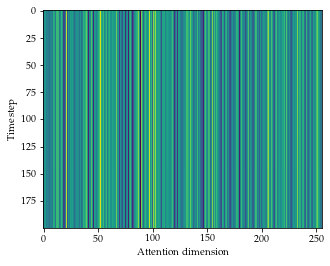

In [413]:
plt.figure(figsize=(5,10))
plt.imshow(att[1])
plt.xlabel('Attention dimension')
plt.ylabel('Time step')
plt.show()

### Using records

We recomend to use `TFRecord`files when having multiples samples. See the tutorial to transform `numpy` light curves to `tfrecord`

In [414]:
from core.data import load_dataset, inference_pipeline

In [418]:
dataset = load_dataset('./data/records/testing/fold_0/testing/test/',
                      shuffle=False, repeat=1)
dataset = inference_pipeline(dataset, 
                             batch_size=256,
                             max_obs=200, 
                             drop_remainder=True)

[INFO] Inference mode. Cutting 200-len windows


In [420]:
%%time
att = model.encode(dataset, concatenate=True)

2022-03-21 13:41:32.325853: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1572864000 exceeds 10% of free system memory.


CPU times: user 2min 10s, sys: 32.5 s, total: 2min 42s
Wall time: 32.1 s


In [422]:
len(att)

846